# Семинар 2. Основной цикл обучения в PyTorch и продвинутые техники обучения

Авторы:
- *Титов Никита Алексеевич* NATitov@fa.ru
- *Уральсков Евгений Александрович*

2.1 Решить задачу классификации предметов одежды, не используя сверточные слои.

    2.1.1 Загрузить датасет, используя классы ``FashionMNIST``, ``DataLoader``
    
    2.1.2 Разделить датасет на тренировочный, валидационный и тестовый
    
    2.1.3 Предложить архитектуру модели для решения задачи

    2.1.4 Обучить модель, используя механизм обучения на мини-батчах

    2.1.5 Во время обучения модели вывести значения функции потерь и метрики качества по эпохам на валидацинном датасете

    2.1.6 После обучения вывести значения функции потерь и метрики качества на тестовом датасете

    2.1.7 Изменить глубину и ширину слоев модели

    2.1.8 Добавить регуляризацию (Dropout-слои, L2-регуляризацию)

    2.1.9 Добавить нормализацию
    
    2.1.10 Визуализировать архитектуру сети в ``Tensorboard``
        
      * [Tensorboard](https://www.tensorflow.org/tensorboard)
      
      * Установка: ``!pip install tensorboard``
      
      * Запуск: ``tensorboard --logdir=runs``
      
      * [Tutorial 1](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)
      
      * [Tutorial 2](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
    
    2.1.11 Построить график функции потерь и метрики качества с помощью ``Tensorboard``
    
    2.1.12 Обучить модель, используя различные оптимизаторы
    
      * [torch.optim](https://pytorch.org/docs/stable/optim.html)
      
      * [pytorch-optimizer](https://github.com/jettify/pytorch-optimizer) - отдельный пакет с еще большим количеством оптимизаторов
      
      * [Сравнение 39 оптимизаторов](https://habr.com/ru/company/prequel/blog/568496/)
    
    2.1.13 Обучить модель, используя различные планировщики скорости обучения
    
      * [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
      
      * [Comparison](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook)
    
    2.1.14 Обучить модель, используя собственную реализацию функции потерь
    
    2.1.15 В качестве метрики качества использовать ``F1 score``
    
    2.1.16 Прервать обучение модели, а потом продолжить его с сохраненного чекпоинта
    
    2.1.17 Экпортировать обученную модель в формат ``ONNX`` и произвести инференс с помощью ``ONNX Runtime``

In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

In [4]:
# выделим из тренировочного датасета 20% данных для валидации
valid_ratio = 0.2
num_valid =  int(valid_ratio * len(train_dataset))
num_train = len(train_dataset) - num_valid

train_dataset, valid_dataset = random_split(dataset=train_dataset, lengths=[num_train, num_valid])

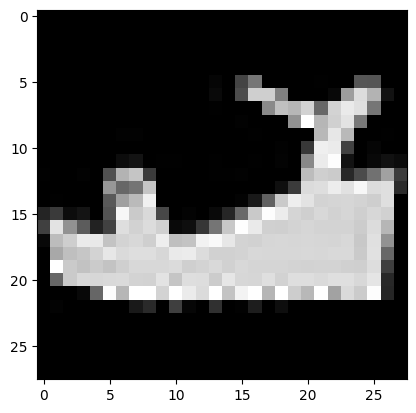

In [5]:
plt.imshow(train_dataset[0][0][0], cmap='gray')

In [6]:
# Делим  датасет на батчи чтобы не предсказывать все 48000 

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# Игрушечная двухслойная сеть

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
def train(model, loader, loss_function, optimizer):
    model.train()

    epoch_loss = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [9]:
def test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        N = 0
        total_loss = 0.0
        correct = 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            N += inputs.shape[0]
            loss = loss_function(outputs, targets)
            total_loss += inputs.shape[0] * loss.item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return total_loss / N, correct / N

In [11]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
print(model.parameters)
optimizer = optim.SGD(model.parameters(), lr=.01)

<bound method Module.parameters of NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)>


In [23]:
print(model.parameters)

<bound method Module.parameters of NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)>


In [40]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 1.161635 Val Loss 0.769006 Val Accuracy 0.744500
---
Epoch 1
Train Loss 0.690694 Val Loss 0.627644 Val Accuracy 0.790333
---
Epoch 2
Train Loss 0.594228 Val Loss 0.569177 Val Accuracy 0.810167
---
Epoch 3
Train Loss 0.545522 Val Loss 0.536859 Val Accuracy 0.816750
---
Epoch 4
Train Loss 0.515387 Val Loss 0.508444 Val Accuracy 0.826250
---
Test Loss 0.533911 Test Accuracy 0.813600


<function matplotlib.pyplot.show(close=None, block=None)>

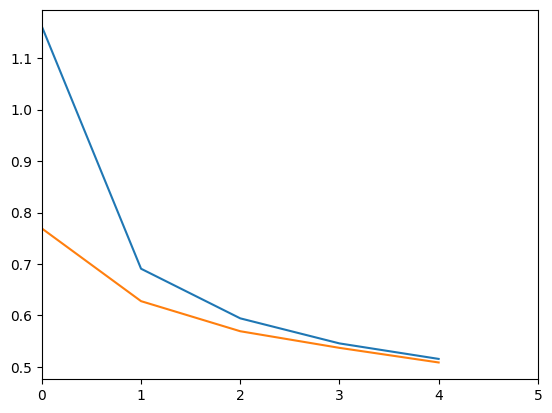

In [41]:
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.show

In [ ]:
# 

Dropout - практика для оптимизации переобучения (выбрасываем нейроны)

In [31]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout() # dropout
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [32]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
optimizer = optim.Adam(model.parameters(), lr=.01)

In [33]:
num_epochs = 15
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 0.779255 Val Loss 0.517941 Val Accuracy 0.816833
---
Epoch 1
Train Loss 0.700930 Val Loss 0.485346 Val Accuracy 0.821500
---
Epoch 2
Train Loss 0.683765 Val Loss 0.479714 Val Accuracy 0.829417
---
Epoch 3
Train Loss 0.659235 Val Loss 0.438185 Val Accuracy 0.847167
---
Epoch 4
Train Loss 0.643064 Val Loss 0.449065 Val Accuracy 0.845750
---
Epoch 5
Train Loss 0.651532 Val Loss 0.467428 Val Accuracy 0.840500
---
Epoch 6
Train Loss 0.650468 Val Loss 0.516128 Val Accuracy 0.814083
---
Epoch 7
Train Loss 0.649873 Val Loss 0.456011 Val Accuracy 0.842667
---
Epoch 8
Train Loss 0.635950 Val Loss 0.443685 Val Accuracy 0.851417
---
Epoch 9
Train Loss 0.630947 Val Loss 0.499569 Val Accuracy 0.846667
---
Epoch 10
Train Loss 0.626667 Val Loss 0.458211 Val Accuracy 0.844583
---
Epoch 11
Train Loss 0.627308 Val Loss 0.456077 Val Accuracy 0.850083
---
Epoch 12
Train Loss 0.623707 Val Loss 0.447242 Val Accuracy 0.849167
---
Epoch 13
Train Loss 0.619294 Val Loss 0.489277 Val Accuracy 0

<function matplotlib.pyplot.show(close=None, block=None)>

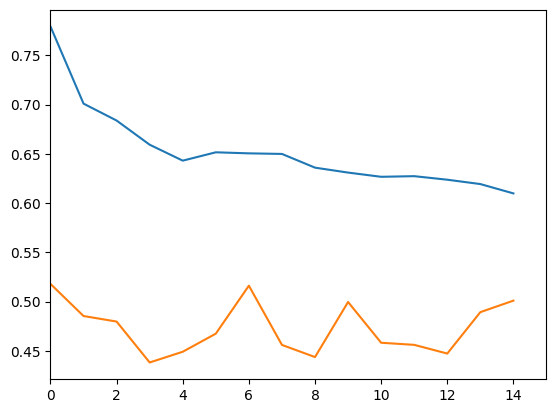

In [34]:
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.show

In [35]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
# weight_decay уменьшает веса на каждой эпохе
optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=0.0001) # L2-регуляризация (штрафует за большие веса)

In [36]:
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 0.588983 Val Loss 0.448246 Val Accuracy 0.841417
---
Epoch 1
Train Loss 0.447777 Val Loss 0.396758 Val Accuracy 0.858250
---
Epoch 2
Train Loss 0.413922 Val Loss 0.390210 Val Accuracy 0.858667
---
Epoch 3
Train Loss 0.397465 Val Loss 0.374568 Val Accuracy 0.863417
---
Epoch 4
Train Loss 0.379667 Val Loss 0.363661 Val Accuracy 0.870000
---
Epoch 5
Train Loss 0.369156 Val Loss 0.355175 Val Accuracy 0.871583
---
Epoch 6
Train Loss 0.361886 Val Loss 0.336269 Val Accuracy 0.880667
---
Epoch 7
Train Loss 0.354662 Val Loss 0.334816 Val Accuracy 0.876667
---
Epoch 8
Train Loss 0.347396 Val Loss 0.330884 Val Accuracy 0.879583
---
Epoch 9
Train Loss 0.344589 Val Loss 0.327225 Val Accuracy 0.881167
---
Test Loss 0.348305 Test Accuracy 0.872400


<function matplotlib.pyplot.show(close=None, block=None)>

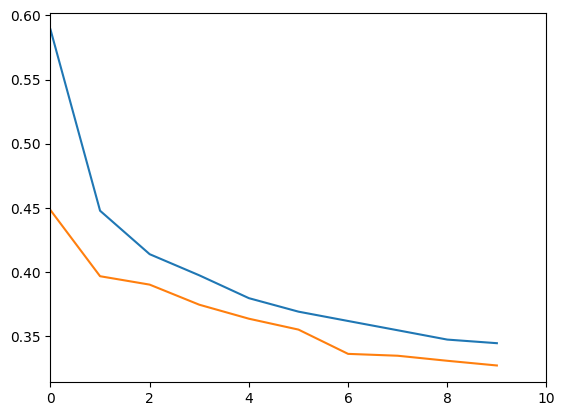

In [37]:
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
plt.show

#### Нормализация

In [43]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout() # dropout
        self.normlayer = nn.BatchNorm1d(hidden_size) # Слой нормализации (дропаут либо нормализация)
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.normlayer(out)
        out = self.fc2(out)
        return out

In [44]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 256
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
# weight_decay уменьшает веса на каждой эпохе
optimizer = optim.Adam(model.parameters(), lr=.001, weight_decay=0.0001) # L2-регуляризация (штрафует за большие веса)

In [45]:
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 0.481152 Val Loss 0.439455 Val Accuracy 0.841417
---
Epoch 1
Train Loss 0.390128 Val Loss 0.403363 Val Accuracy 0.859750
---
Epoch 2
Train Loss 0.363926 Val Loss 0.390225 Val Accuracy 0.864167
---
Epoch 3
Train Loss 0.345577 Val Loss 0.370844 Val Accuracy 0.875250
---
Epoch 4
Train Loss 0.332217 Val Loss 0.368406 Val Accuracy 0.872000
---
Epoch 5
Train Loss 0.318666 Val Loss 0.373018 Val Accuracy 0.870750
---
Epoch 6
Train Loss 0.308007 Val Loss 0.372228 Val Accuracy 0.868750
---
Epoch 7
Train Loss 0.299497 Val Loss 0.373315 Val Accuracy 0.871917
---
Epoch 8
Train Loss 0.292202 Val Loss 0.360679 Val Accuracy 0.873333
---
Epoch 9
Train Loss 0.285219 Val Loss 0.345410 Val Accuracy 0.882583
---
Test Loss 0.363458 Test Accuracy 0.873700


<function matplotlib.pyplot.show(close=None, block=None)>

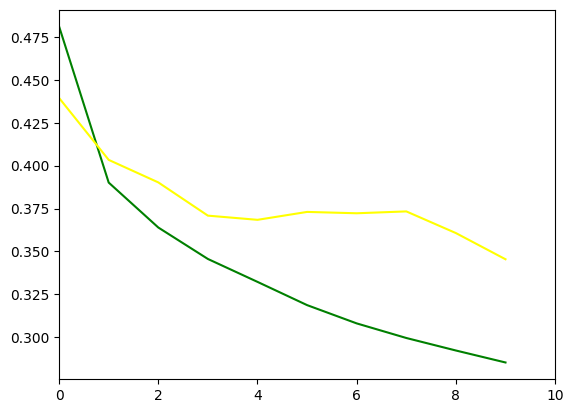

In [48]:
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
plt.plot(range(len(train_losses)), train_losses, color="green")
plt.plot(range(len(val_losses)), val_losses, color="yellow")
plt.show

#### Поменяем  функцию активации на гиперболический тангенс (возвращает от 1 до -1 (пологий график, не часто используется в глубоких сетях))

![image](https://i.ibb.co/txZXQWR/Screenshot-2023-03-06-164152.png)

## ONNX

* [ONNX](https://onnx.ai/)

* [ONNX Runtime](https://onnxruntime.ai/)

### Перенос обученной модели из одного фреймворка в другой
 
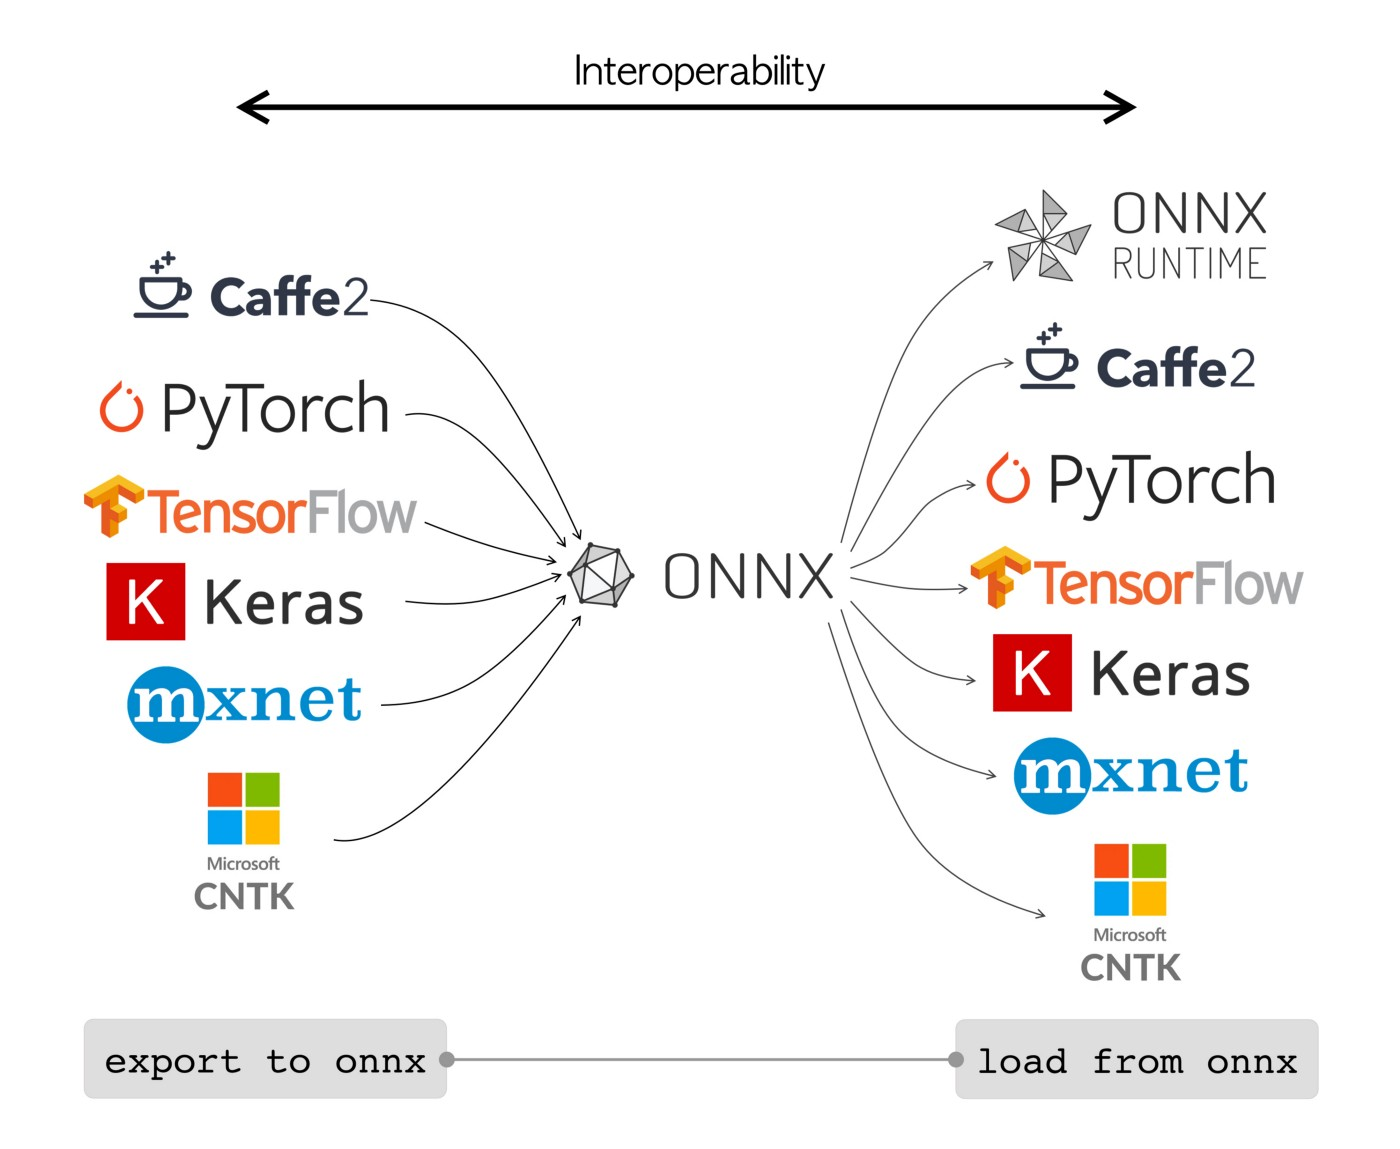
 
 ### Ускорение инференса модели на различных девайсах

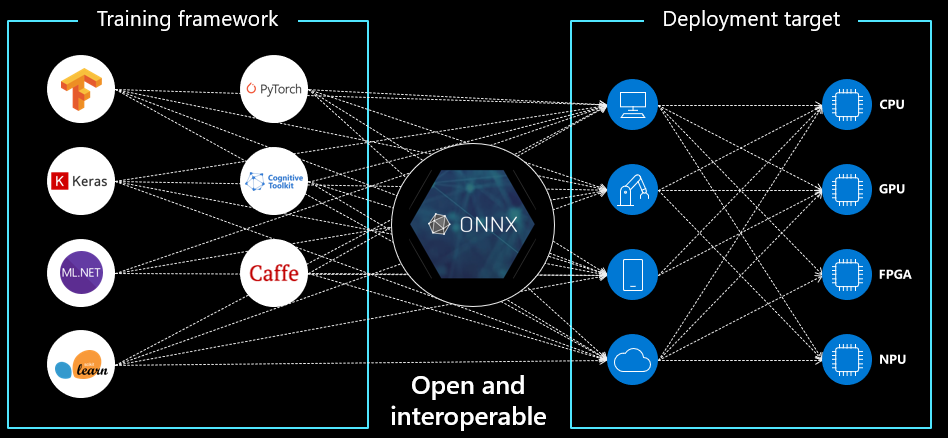

In [ ]:
%%javascript

requirejs.config({
    paths: { 
        'onnx': ['https://cdn.jsdelivr.net/npm/onnxjs/dist/onnx.min'],
    },
});


require(['onnx']);

In [ ]:
%%javascript

const rawX = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04313725605607033, 0.0941176488995552, 0.0784313753247261, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10588235408067703, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003921568859368563, 0.003921568859368563, 0.0, 0.0, 0.027450980618596077, 0.529411792755127, 0.34117648005485535, 0.2980392277240753, 0.3764705955982208, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9725490212440491, 0.7215686440467834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5490196347236633, 0.7843137383460999, 0.0941176488995552, 0.3686274588108063, 0.5098039507865906, 0.4470588266849518, 0.03529411926865578, 0.0, 0.0, 0.0, 0.7098039388656616, 0.7568627595901489, 0.8980392217636108, 0.1882352977991104, 0.0, 0.0, 0.0, 0.0, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12941177189350128, 0.5960784554481506, 0.5686274766921997, 0.26274511218070984, 0.4313725531101227, 0.8039215803146362, 0.1725490242242813, 0.2549019753932953, 0.8156862854957581, 0.6470588445663452, 0.45098039507865906, 0.5529412031173706, 0.8588235378265381, 0.7333333492279053, 0.7803921699523926, 0.5686274766921997, 0.0, 0.003921568859368563, 0.0, 0.0, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.250980406999588, 0.5529412031173706, 0.5490196347236633, 0.6078431606292725, 0.5215686559677124, 0.21568627655506134, 0.8784313797950745, 0.658823549747467, 0.32549020648002625, 0.09803921729326248, 0.07450980693101883, 0.34117648005485535, 0.3764705955982208, 0.1568627506494522, 0.4941176474094391, 0.7568627595901489, 0.772549033164978, 0.8823529481887817, 0.03529411926865578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0235294122248888, 0.13333334028720856, 0.2549019753932953, 0.4313725531101227, 0.26274511218070984, 0.1411764770746231, 0.15294118225574493, 0.25882354378700256, 0.21960784494876862, 0.8352941274642944, 0.8627451062202454, 0.8980392217636108, 0.6901960968971252, 0.3450980484485626, 0.0941176488995552, 0.12941177189350128, 0.2235294133424759, 0.16078431904315948, 0.364705890417099, 0.47058823704719543, 0.42352941632270813, 0.0, 0.0, 0.054901961237192154, 0.19607843458652496, 0.01568627543747425, 0.0470588244497776, 0.08627451211214066, 0.125490203499794, 0.21960784494876862, 0.1725490242242813, 0.16862745583057404, 0.21176470816135406, 0.16078431904315948, 0.1568627506494522, 0.19607843458652496, 0.10980392247438431, 0.29411765933036804, 0.5490196347236633, 0.6509804129600525, 0.8901960849761963, 0.9960784316062927, 0.7568627595901489, 0.3843137323856354, 0.29411765933036804, 0.4745098054409027, 0.4431372582912445, 0.3960784375667572, 0.364705890417099, 0.0, 0.007843137718737125, 0.25882354378700256, 0.40392157435417175, 0.33725491166114807, 0.3607843220233917, 0.3764705955982208, 0.32549020648002625, 0.2666666805744171, 0.27450981736183167, 0.3176470696926117, 0.32549020648002625, 0.38823530077934265, 0.29411765933036804, 0.2235294133424759, 0.2862745225429535, 0.1764705926179886, 0.1568627506494522, 0.12941177189350128, 0.1921568661928177, 0.4313725531101227, 0.9058823585510254, 0.8392156958580017, 0.42352941632270813, 0.40392157435417175, 0.38823530077934265, 0.3803921639919281, 0.42352941632270813, 0.01568627543747425, 0.33725491166114807, 0.42352941632270813, 0.2980392277240753, 0.2823529541492462, 0.29411765933036804, 0.3176470696926117, 0.3450980484485626, 0.364705890417099, 0.3843137323856354, 0.3450980484485626, 0.33725491166114807, 0.38823530077934265, 0.4000000059604645, 0.35686275362968445, 0.30588236451148987, 0.3137255012989044, 0.3176470696926117, 0.3137255012989044, 0.2980392277240753, 0.27843138575553894, 0.29411765933036804, 0.27450981736183167, 0.3450980484485626, 0.4274509847164154, 0.4000000059604645, 0.3960784375667572, 0.40784314274787903, 0.0, 0.21960784494876862, 0.43921568989753723, 0.4000000059604645, 0.38823530077934265, 0.42352941632270813, 0.3607843220233917, 0.364705890417099, 0.3803921639919281, 0.3176470696926117, 0.3450980484485626, 0.3764705955982208, 0.3686274588108063, 0.35686275362968445, 0.3490196168422699, 0.4274509847164154, 0.33725491166114807, 0.3803921639919281, 0.40392157435417175, 0.545098066329956, 0.5098039507865906, 0.501960813999176, 0.572549045085907, 0.47058823704719543, 0.42352941632270813, 0.501960813999176, 0.5529412031173706, 0.47058823704719543, 0.0470588244497776, 0.0, 0.20392157137393951, 0.40784314274787903, 0.35686275362968445, 0.38823530077934265, 0.364705890417099, 0.4627451002597809, 0.27450981736183167, 0.5058823823928833, 0.3764705955982208, 0.4117647111415863, 0.4745098054409027, 0.4470588266849518, 0.5921568870544434, 0.529411792755127, 0.5372549295425415, 0.6196078658103943, 0.24313725531101227, 0.3686274588108063, 0.23529411852359772, 0.24313725531101227, 0.5764706134796143, 0.29411765933036804, 0.16078431904315948, 0.4000000059604645, 0.3764705955982208, 0.7372549176216125, 0.239215686917305, 0.0, 0.0, 0.027450980618596077, 0.20392157137393951, 0.23529411852359772, 0.38823530077934265, 0.5490196347236633, 0.21960784494876862, 0.6470588445663452, 0.3137255012989044, 0.3960784375667572, 0.5215686559677124, 0.38823530077934265, 0.5843137502670288, 0.4588235318660736, 0.4000000059604645, 0.5490196347236633, 0.48627451062202454, 0.6196078658103943, 0.4627451002597809, 0.27450981736183167, 0.7215686440467834, 0.5529412031173706, 0.3843137323856354, 0.6000000238418579, 0.3137255012989044, 0.48235294222831726, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027450980618596077, 0.10588235408067703, 0.03529411926865578, 0.26274511218070984, 0.16862745583057404, 0.19607843458652496, 0.1921568661928177, 0.12941177189350128, 0.16862745583057404, 0.13333334028720856, 0.10980392247438431, 0.0784313753247261, 0.08627451211214066, 0.11372549086809158, 0.062745101749897, 0.0117647061124444, 0.13725490868091583, 0.07450980693101883, 0.0470588244497776, 0.10588235408067703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

async function runExample() {
    const session = new onnx.InferenceSession();
    
    ...
    
}


runExample();

2.1.10 Визуализировать архитектуру сети в ``Tensorboard``
        
      * [Tensorboard](https://www.tensorflow.org/tensorboard)
      
      * Установка: ``!pip install tensorboard``
      
      * Запуск: ``tensorboard --logdir=runs``
      
      * [Tutorial 1](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)
      
      * [Tutorial 2](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
    
    2.1.11 Построить график функции потерь и метрики качества с помощью ``Tensorboard``

In [61]:
from torch.utils.tensorboard import SummaryWriter

tb = SummaryWriter()
print(model.parameters)

tb.add_graph(model, next(iter(train_loader))[0].to(DEVICE))
tb.close()

<bound method Module.parameters of NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (normlayer): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)>


<a href="https://ibb.co/jJ6W4KT"><img src="https://i.ibb.co/FHx07vK/Screenshot-2023-03-06-173150.png" alt="Screenshot-2023-03-06-173150" border="0"></a>

In [62]:
tb = SummaryWriter()

layout = {
    "FashionMNIST": {
        "Loss": ["Multiline", ["loss/train", "loss/valid"]],
        "Accuracy": ["Multiline", ["accuracy/valid", "accuracy/test"]],
        "Learning_rate": ["Multiline", ["lr"]]
    }
}

tb.add_custom_scalars(layout)

In [63]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("accuracy/valid", val_acc, epoch)
    tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("accuracy/test", test_acc, epoch)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 0.330298 Val Loss 0.354482 Val Accuracy 0.875667
---
Epoch 1
Train Loss 0.330248 Val Loss 0.354747 Val Accuracy 0.875500
---
Epoch 2
Train Loss 0.331441 Val Loss 0.353019 Val Accuracy 0.875917
---
Epoch 3
Train Loss 0.330500 Val Loss 0.353405 Val Accuracy 0.874917
---
Epoch 4
Train Loss 0.331088 Val Loss 0.354002 Val Accuracy 0.875000
---
Test Loss 0.378452 Test Accuracy 0.863500


<a href="https://ibb.co/GcsnrsC"><img src="https://i.ibb.co/LnQYsQ9/Screenshot-2023-03-06-175511.png" alt="Screenshot-2023-03-06-175511" border="0"></a><br /><a target='_blank' href='https://ru.imgbb.com/'>где найти бесплатные фото для сайта</a><br />

Видим, что learning rate постоянный как и задавали

Теперь сделаем динамический learning rate с помощью scheduler

In [64]:
def train(model, loader, loss_function, optimizer, scheduler=None):
    model.train()

    epoch_loss = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    if scheduler is not None:
        scheduler.step()
        
    return epoch_loss / len(loader)

In [65]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


In [66]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    val_loss, val_acc = test(model=model, loader=valid_loader, loss_function=criterion)
    

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("accuracy/valid", val_acc, epoch)
    tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)

test_loss, test_acc = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("accuracy/test", test_acc, epoch)
print(f'Test Loss {test_loss:.6f} Test Accuracy {test_acc:.6f}')

Epoch 0
Train Loss 0.476239 Val Loss 0.439238 Val Accuracy 0.846833
---
Epoch 1
Train Loss 0.363795 Val Loss 0.369794 Val Accuracy 0.870333
---
Epoch 2
Train Loss 0.339625 Val Loss 0.362887 Val Accuracy 0.871250
---
Epoch 3
Train Loss 0.335774 Val Loss 0.362720 Val Accuracy 0.871833
---
Epoch 4
Train Loss 0.336715 Val Loss 0.362400 Val Accuracy 0.871167
---
Test Loss 0.381069 Test Accuracy 0.863500


Теперь давайте менять learning rate по косинусу

In [ ]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, T_max=5, eta_min=1e-6)


In [ ]:
def test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        N = 0
        total_loss = 0.0
        correct = 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            N += inputs.shape[0]
            loss = loss_function(outputs, targets)
            total_loss += inputs.shape[0] * loss.item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return total_loss / N, correct / N

Ы

In [67]:
# Добавляет большие штрафы за неправильно распознанный класс сандали
# старается получать меньший штраф и лучше угадывать сандали

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        mask = target == 5 # sandal (пример одежди сандали)
        delta = (loss * mask.to(torch.float32)).mean() # batch mean
        return loss + delta

In [ ]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
optimizer = optim.Adam(model.parameters(), lr=.001)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, T_max=5, eta_min=1e-6)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)


<a href="https://ibb.co/3WrsnR2"><img src="https://i.ibb.co/Mp2hmBr/Screenshot-2023-03-06-182331.png" alt="Screenshot-2023-03-06-182331" border="0"></a>

Можно использовать также кастомную метрику вместо кастомного класса

Хотим вместо accuracy считать f1 меру

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        N = 0
        total_loss = 0.0
        target_epoch = []
        predicted_epoch = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            N += inputs.shape[0]
            loss = loss_function(outputs, targets)
            total_loss += inputs.shape[0] * loss.item()
            predicted_targets = outputs.argmax(dim=1)
            target_epoch.append(targets.detach().cpu().numpy()) # надо в cpu тк sklearn не умеет работать с тензорами
            predicted_epoch.append(predicted_targets.detach().cpu().numpy())

        f1 = f1_score(
            # конкатенируем в два длинных вектора
            np.concatenate(target_epoch),
            np.concatenate(predicted_epoch),
            average="macro",
        )
        
        return total_loss / N, f1

In [ ]:
tb = SummaryWriter()

layout = {
    "FashionMNIST": {
        "Loss": ["Multiline", ["loss/train", "loss/valid"]],
        "Accuracy": ["Multiline", ["accuracy/valid", "accuracy/test"]],
        "F1": ["Multiline", ["f1/valid"]]
    }
}

tb.add_custom_scalars(layout)

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    val_loss, val_f1 = test(model=model, loader=valid_loader, loss_function=criterion)
    

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("f1/valid", val_f1, epoch)
    tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)

test_loss, test_f1 = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("f1/test", test_f1, epoch)
print(f'Test Loss {test_loss:.6f} Test F1 {test_f1:.6f}')

<a href="https://ibb.co/2dMxdxs"><img src="https://i.ibb.co/L1gm1mJ/Screenshot-2023-03-06-183524.png" alt="Screenshot-2023-03-06-183524" border="0"></a>

Если хотим сохранить модель для дальнейшего обучения (создание чекпоинта)

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    val_loss, val_f1 = test(model=model, loader=valid_loader, loss_function=criterion)
    

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # print(f'Epoch {epoch}')
    # print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    # print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("f1/valid", val_f1, epoch)
    # tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)
    
    # Сохранение
    if epoch % 5 == 0:
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }, f"model-{epoch}.pth")


test_loss, test_f1 = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("f1/test", test_f1, epoch)
print(f'Test Loss {test_loss:.6f} Test F1 {test_f1:.6f}')

In [ ]:
input_size = test_dataset.data[0, :].numel()
hidden_size = 512
num_classes = len(test_dataset.classes)
model = NeuralNet(input_size, hidden_size, num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss() # CCE для задач классификации
optimizer = optim.Adam(model.parameters(), lr=.001)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, T_max=5, eta_min=1e-6)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

checkpoint = torch.load("./model-10.pth") # загрузка состояний в объект
model.load_state_dict(checkpoint["model_state_dict"]) # инициализация объекта с весами
optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) # тоже самое для оптимизатора

In [ ]:
# запускаем еще 5 эпох обучаться

num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(10, 10+num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    val_loss, val_f1 = test(model=model, loader=valid_loader, loss_function=criterion)
    

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # print(f'Epoch {epoch}')
    # print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    # print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("f1/valid", val_f1, epoch)
    # tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)
    
    # # Сохранение
    # if epoch % 5 == 0:
    #     torch.save({
    #         "epoch": epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict()
    #     }, f"model-{epoch}.pth")


test_loss, test_f1 = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("f1/test", test_f1, epoch)
print(f'Test Loss {test_loss:.6f} Test F1 {test_f1:.6f}')

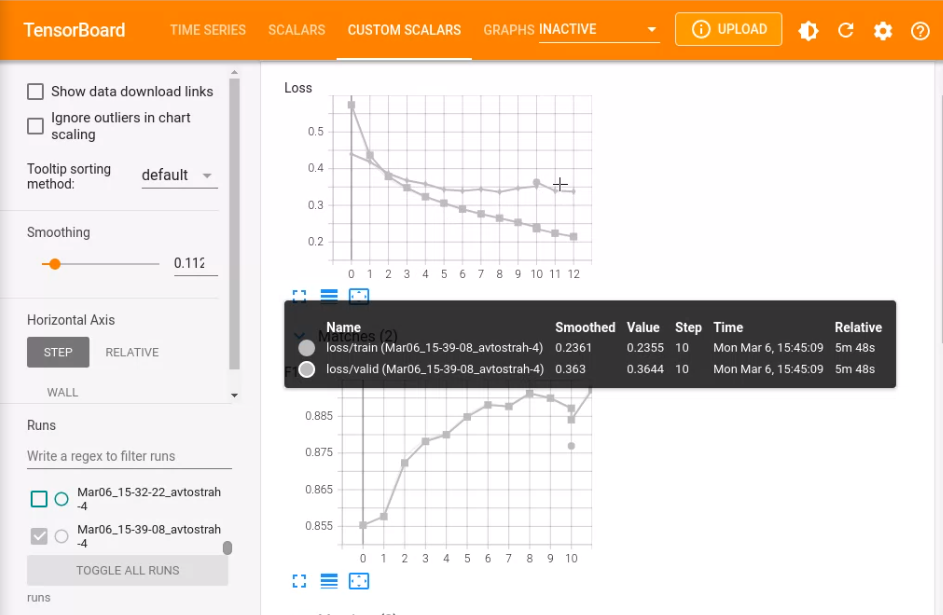

Перенос модели из разных фреймворков и сред обучения (разные железные архитектуры)
и впоследствие запускать на разных устройствах

На помощь приходит ONNX

Из pytorch в onnx runtime

In [ ]:
# Onnx ломается на измерениях 

BATCHSIZE = 64


train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCHSIZE, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, drop_last=True)

# Игрушечная двухслойная сеть
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        # x = x.view(x.size()[0], -1)
        x = x.view(BATCHSIZE, -1)
        
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
# запускаем еще 5 эпох обучаться

num_epochs = 5
train_losses = []
val_losses = []
for epoch in range(10, 10+num_epochs):
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    val_loss, val_f1 = test(model=model, loader=valid_loader, loss_function=criterion)
    

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # print(f'Epoch {epoch}')
    # print(f'Train Loss {train_loss:.6f} Val Loss {val_loss:.6f} Val Accuracy {val_acc:.6f}')
    # print('---')
    tb.add_scalar("loss/train", train_loss, epoch)
    tb.add_scalar("loss/valid", val_loss, epoch)
    tb.add_scalar("f1/valid", val_f1, epoch)
    # tb.add_scalar("lr", torch.tensor(optimizer.param_groups[0]["lr"], dtype=torch.float32), epoch)
    
    # # Сохранение
    # if epoch % 5 == 0:
    #     torch.save({
    #         "epoch": epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict()
    #     }, f"model-{epoch}.pth")


test_loss, test_f1 = test(model=model, loader=test_loader, loss_function=criterion)
tb.add_scalar("f1/test", test_f1, epoch)
print(f'Test Loss {test_loss:.6f} Test F1 {test_f1:.6f}')

In [ ]:
import torch.onnx

torch.onnx.export(model, next(iter(train_loader))[0].to(DEVICE),
                  "FashionMNIST_model.onnx",
                  input_names=["images"]) # назовем инпуты (входной слой ) нашими изображениями

In [ ]:
# Загрузим эту модель
# Установим onnx и onnx runtime
import onnx

onnx_model = onnx.load("./FashionMNIST_model.onnx")
onnx.checker.check_model(onnx_model)

print(onnx.helper.printable_graph(onnx_model.graph))

In [68]:
# Запустим в питоне / можно хоть в js

import onnxruntime as ort
import numpy as num_epochs
from PIL import Image

x = Image.open("./7.png") # картинка кроссовка (есть ниже)
# /255 потому что изображения были нормированы от 0 до 1
x = (np.asarray(x, dtype=np.float32) / 255).reshape(1, 1, 28, 28)

batch = np.vstack([x] * 64)

ort_sess = ort.InferemceSession("./FashionMNIST_model.onnx")
outputs = ort_sess.run(None, {"images": batch})

print(f"Predicted: {outputs[0][0].argmax(0)}")

# Predicted: 7 (модель угадала, класс 7 - кроссовки)



KeyboardInterrupt



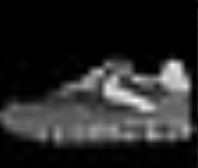

In [ ]:
# Сделаем на 
# Загружаем библиотеки

%%javascript

requirejs.config({
    paths: { 
        'onnx': ['https://cdn.jsdelivr.net/npm/onnxjs/dist/onnx.min'],
    },
});


require(['onnx']);

In [ ]:
%%javascript

# Заранее считали файл кроссовок в виде списка
const rawX = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04313725605607033, 0.0941176488995552, 0.0784313753247261, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10588235408067703, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003921568859368563, 0.003921568859368563, 0.0, 0.0, 0.027450980618596077, 0.529411792755127, 0.34117648005485535, 0.2980392277240753, 0.3764705955982208, 0.0, 0.0, 0.0, 0.0, 0.32549020648002625, 0.9725490212440491, 0.7215686440467834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5490196347236633, 0.7843137383460999, 0.0941176488995552, 0.3686274588108063, 0.5098039507865906, 0.4470588266849518, 0.03529411926865578, 0.0, 0.0, 0.0, 0.7098039388656616, 0.7568627595901489, 0.8980392217636108, 0.1882352977991104, 0.0, 0.0, 0.0, 0.0, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12941177189350128, 0.5960784554481506, 0.5686274766921997, 0.26274511218070984, 0.4313725531101227, 0.8039215803146362, 0.1725490242242813, 0.2549019753932953, 0.8156862854957581, 0.6470588445663452, 0.45098039507865906, 0.5529412031173706, 0.8588235378265381, 0.7333333492279053, 0.7803921699523926, 0.5686274766921997, 0.0, 0.003921568859368563, 0.0, 0.0, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.250980406999588, 0.5529412031173706, 0.5490196347236633, 0.6078431606292725, 0.5215686559677124, 0.21568627655506134, 0.8784313797950745, 0.658823549747467, 0.32549020648002625, 0.09803921729326248, 0.07450980693101883, 0.34117648005485535, 0.3764705955982208, 0.1568627506494522, 0.4941176474094391, 0.7568627595901489, 0.772549033164978, 0.8823529481887817, 0.03529411926865578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0235294122248888, 0.13333334028720856, 0.2549019753932953, 0.4313725531101227, 0.26274511218070984, 0.1411764770746231, 0.15294118225574493, 0.25882354378700256, 0.21960784494876862, 0.8352941274642944, 0.8627451062202454, 0.8980392217636108, 0.6901960968971252, 0.3450980484485626, 0.0941176488995552, 0.12941177189350128, 0.2235294133424759, 0.16078431904315948, 0.364705890417099, 0.47058823704719543, 0.42352941632270813, 0.0, 0.0, 0.054901961237192154, 0.19607843458652496, 0.01568627543747425, 0.0470588244497776, 0.08627451211214066, 0.125490203499794, 0.21960784494876862, 0.1725490242242813, 0.16862745583057404, 0.21176470816135406, 0.16078431904315948, 0.1568627506494522, 0.19607843458652496, 0.10980392247438431, 0.29411765933036804, 0.5490196347236633, 0.6509804129600525, 0.8901960849761963, 0.9960784316062927, 0.7568627595901489, 0.3843137323856354, 0.29411765933036804, 0.4745098054409027, 0.4431372582912445, 0.3960784375667572, 0.364705890417099, 0.0, 0.007843137718737125, 0.25882354378700256, 0.40392157435417175, 0.33725491166114807, 0.3607843220233917, 0.3764705955982208, 0.32549020648002625, 0.2666666805744171, 0.27450981736183167, 0.3176470696926117, 0.32549020648002625, 0.38823530077934265, 0.29411765933036804, 0.2235294133424759, 0.2862745225429535, 0.1764705926179886, 0.1568627506494522, 0.12941177189350128, 0.1921568661928177, 0.4313725531101227, 0.9058823585510254, 0.8392156958580017, 0.42352941632270813, 0.40392157435417175, 0.38823530077934265, 0.3803921639919281, 0.42352941632270813, 0.01568627543747425, 0.33725491166114807, 0.42352941632270813, 0.2980392277240753, 0.2823529541492462, 0.29411765933036804, 0.3176470696926117, 0.3450980484485626, 0.364705890417099, 0.3843137323856354, 0.3450980484485626, 0.33725491166114807, 0.38823530077934265, 0.4000000059604645, 0.35686275362968445, 0.30588236451148987, 0.3137255012989044, 0.3176470696926117, 0.3137255012989044, 0.2980392277240753, 0.27843138575553894, 0.29411765933036804, 0.27450981736183167, 0.3450980484485626, 0.4274509847164154, 0.4000000059604645, 0.3960784375667572, 0.40784314274787903, 0.0, 0.21960784494876862, 0.43921568989753723, 0.4000000059604645, 0.38823530077934265, 0.42352941632270813, 0.3607843220233917, 0.364705890417099, 0.3803921639919281, 0.3176470696926117, 0.3450980484485626, 0.3764705955982208, 0.3686274588108063, 0.35686275362968445, 0.3490196168422699, 0.4274509847164154, 0.33725491166114807, 0.3803921639919281, 0.40392157435417175, 0.545098066329956, 0.5098039507865906, 0.501960813999176, 0.572549045085907, 0.47058823704719543, 0.42352941632270813, 0.501960813999176, 0.5529412031173706, 0.47058823704719543, 0.0470588244497776, 0.0, 0.20392157137393951, 0.40784314274787903, 0.35686275362968445, 0.38823530077934265, 0.364705890417099, 0.4627451002597809, 0.27450981736183167, 0.5058823823928833, 0.3764705955982208, 0.4117647111415863, 0.4745098054409027, 0.4470588266849518, 0.5921568870544434, 0.529411792755127, 0.5372549295425415, 0.6196078658103943, 0.24313725531101227, 0.3686274588108063, 0.23529411852359772, 0.24313725531101227, 0.5764706134796143, 0.29411765933036804, 0.16078431904315948, 0.4000000059604645, 0.3764705955982208, 0.7372549176216125, 0.239215686917305, 0.0, 0.0, 0.027450980618596077, 0.20392157137393951, 0.23529411852359772, 0.38823530077934265, 0.5490196347236633, 0.21960784494876862, 0.6470588445663452, 0.3137255012989044, 0.3960784375667572, 0.5215686559677124, 0.38823530077934265, 0.5843137502670288, 0.4588235318660736, 0.4000000059604645, 0.5490196347236633, 0.48627451062202454, 0.6196078658103943, 0.4627451002597809, 0.27450981736183167, 0.7215686440467834, 0.5529412031173706, 0.3843137323856354, 0.6000000238418579, 0.3137255012989044, 0.48235294222831726, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027450980618596077, 0.10588235408067703, 0.03529411926865578, 0.26274511218070984, 0.16862745583057404, 0.19607843458652496, 0.1921568661928177, 0.12941177189350128, 0.16862745583057404, 0.13333334028720856, 0.10980392247438431, 0.0784313753247261, 0.08627451211214066, 0.11372549086809158, 0.062745101749897, 0.0117647061124444, 0.13725490868091583, 0.07450980693101883, 0.0470588244497776, 0.10588235408067703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

async function runExample() {
    const session = new onnx.InferenceSession();
    
    await session.loadModel("./FashionMNIST_model.onnx")

    const x = new Float32Array(rawX)

    let batch = []
    for (let i = 0; i < 64; ++i) {
        batch.push(x);

    }

    batch = batch.map(a => [...a]).flat();

    const tensorX = new onnx.Tensor(batch, "float32", [64, 1, 28, 28]);
    
    const outputMap = await session.run([tensorX]);
    const outputData = outputMap.values().next().value;

    const result = outputData.data.slice(0, 10);
    onst classIdx = result.indexOf(Math.max(...result));

    alert(`Predicted: ${classIdx}`);
    
}


runExample();

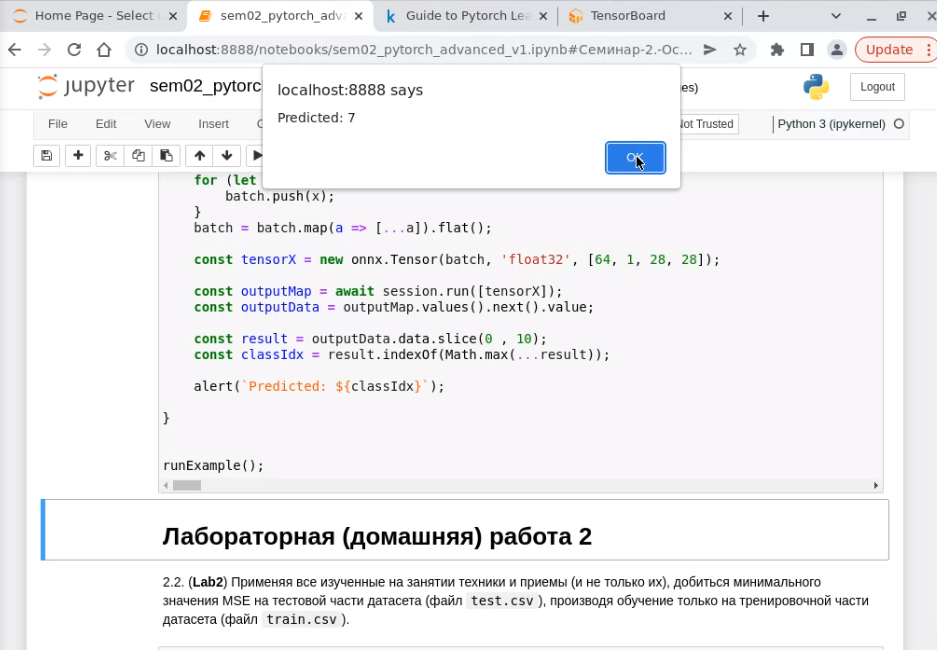

Успешно определили класс с использованием js

# Лабораторная (домашняя) работа 2

2.2. (**Lab2**) Применяя все изученные на занятии техники и приемы (и не только их), добиться минимального значения MSE на тестовой части датасета (файл ``test.csv``), производя обучение только на тренировочной части датасета (файл ``train.csv``).

In [69]:
# Соревнование, нужно всё что прошли и не только применить, обучить нейросеть 
# и проанализировать минимально возможной функции ошибки на test.csv